# Truncated singular value decomposition and latent semantic analysis

In [1]:
###################### Clustering text documents using k-means ###############################

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# parse commandline arguments
op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()

def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.


In [6]:

# #############################################################################
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
# categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]


print("Extracting features from the training dataset "
      "using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words='english', alternate_sign=False,
                                   norm=None, binary=False)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words='english',
                                       alternate_sign=False, norm='l2',
                                       binary=False)
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)
X = vectorizer.fit_transform(dataset.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()

2019-10-25 17:38:48,152 INFO Downloading 20news dataset. This may take a few minutes.
2019-10-25 17:38:48,154 INFO Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories

Extracting features from the training dataset using a sparse vectorizer
done in 0.773669s
n_samples: 3387, n_features: 10000



In [7]:
# #############################################################################
# Do the actual clustering

if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()


if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=4, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=False)
done in 0.107s

Homogeneity: 0.605
Completeness: 0.645
V-measure: 0.624
Adjusted Rand-Index: 0.569
Silhouette Coefficient: 0.008

Top terms per cluster:
Cluster 0: graphics image university thanks file files 3d ac posting help
Cluster 1: space nasa access gov digex pat shuttle hst alaska net
Cluster 2: god com people sandvik don article keith jesus say think
Cluster 3: henry toronto com moon zoo spencer article space like zoology


# Dictionary Learning

## Sparse coding with a precomputed dictionary

Orthogonal matching pursuit (Orthogonal Matching Pursuit (OMP))

Least-angle regression (Least Angle Regression)

Lasso computed by least-angle regression

Lasso using coordinate descent (Lasso)

Thresholding

Automatically created module for IPython interactive environment


C:\Users\xzzz\Anaconda3\lib\site-packages\sklearn\decomposition\dict_learning.py:171: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_Xy=copy_cov).T


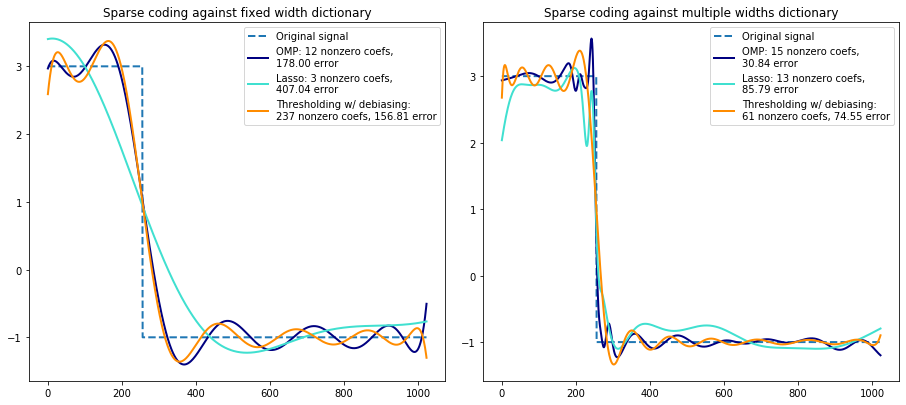

In [28]:
#sklearn.decomposition.SparseCoder
print(__doc__)

from distutils.version import LooseVersion

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import SparseCoder


def ricker_function(resolution, center, width):
    """Discrete sub-sampled Ricker (Mexican hat) wavelet"""
    x = np.linspace(0, resolution - 1, resolution)
    x = ((2 / ((np.sqrt(3 * width) * np.pi ** 1 / 4)))
         * (1 - ((x - center) ** 2 / width ** 2))
         * np.exp((-(x - center) ** 2) / (2 * width ** 2)))
    return x


def ricker_matrix(width, resolution, n_components):
    """Dictionary of Ricker (Mexican hat) wavelets"""
    centers = np.linspace(0, resolution - 1, n_components)
    D = np.empty((n_components, resolution))
    for i, center in enumerate(centers):
        D[i] = ricker_function(resolution, center, width)
    D /= np.sqrt(np.sum(D ** 2, axis=1))[:, np.newaxis]
    return D


resolution = 1024
subsampling = 3  # subsampling factor
width = 300                         ####adding different widths of atoms matters and 
                                   #### it therefore motivates learning the dictionary to best fit your type of signals.
n_components = resolution // subsampling

# Compute a wavelet dictionary
D_fixed = ricker_matrix(width=width, resolution=resolution,
                        n_components=n_components)
D_multi = np.r_[tuple(ricker_matrix(width=w, resolution=resolution,
                      n_components=n_components // 5)
                for w in (10,50,100,500))]##################### multiple width  ######################

# Generate a signal
y = np.linspace(0, resolution - 1, resolution)
first_quarter = y < resolution / 4
y[first_quarter] = 3.
y[np.logical_not(first_quarter)] = -1.

# List the different sparse coding methods in the following format:
# (title, transform_algorithm, transform_alpha,
#  transform_n_nozero_coefs, color)
estimators = [('OMP', 'omp', None, 15, 'navy'),
              ('Lasso', 'lasso_lars', 2, None, 'turquoise'), ]
lw = 2
# Avoid FutureWarning about default value change when numpy >= 1.14
lstsq_rcond = None if LooseVersion(np.__version__) >= '1.14' else -1

plt.figure(figsize=(13, 6))
for subplot, (D, title) in enumerate(zip((D_fixed, D_multi),
                                         ('fixed width', 'multiple widths'))):
    plt.subplot(1, 2, subplot + 1)
    plt.title('Sparse coding against %s dictionary' % title)
    plt.plot(y, lw=lw, linestyle='--', label='Original signal')

        # Do a wavelet approximation
    for title, algo, alpha, n_nonzero, color in estimators:########### OMP and Lasso ######
        coder = SparseCoder(dictionary=D, transform_n_nonzero_coefs=n_nonzero,
                            transform_alpha=alpha, transform_algorithm=algo)
        x = coder.transform(y.reshape(1, -1))
        density = len(np.flatnonzero(x))
        x = np.ravel(np.dot(x, D))
        squared_error = np.sum((y - x) ** 2)
        
        plt.plot(x, color=color, lw=lw,
                 label='%s: %s nonzero coefs,\n%.2f error'
                 % (title, density, squared_error))

    # Soft thresholding debiasing
    coder = SparseCoder(dictionary=D, transform_algorithm='threshold',
                        transform_alpha=20)
    x = coder.transform(y.reshape(1, -1))
    _, idx = np.where(x != 0)
    x[0, idx], _, _, _ = np.linalg.lstsq(D[idx, :].T, y, rcond=lstsq_rcond)
    x = np.ravel(np.dot(x, D))
    squared_error = np.sum((y - x) ** 2)
    
    plt.plot(x, color='darkorange', lw=lw,
             label='Thresholding w/ debiasing:\n%d nonzero coefs, %.2f error'
             % (len(idx), squared_error))
    plt.axis('tight')
    plt.legend(shadow=False, loc='best')
plt.subplots_adjust(.04, .07, .97, .90, .09, .2)
plt.show()

## Generic dictionary learning

In [ ]:
##Image denoising using dictionary learning

 Orthogonal Matching Pursuit (OMP) 效果最好，保留1个或是2个系数差异不大，Least Angle Regression偏差较大，Thresholding 不适于可视化

Automatically created module for IPython interactive environment
Distorting image...
Extracting reference patches...
done in 0.02s.
Learning the dictionary...
done in 3.40s.


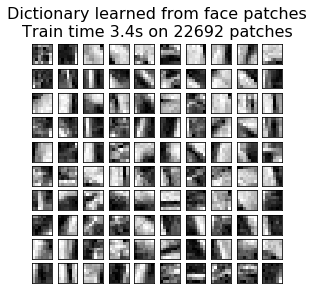

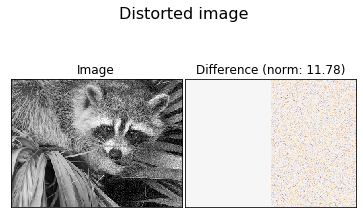

In [31]:
print(__doc__)

from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d


try:  # SciPy >= 0.16 have face in misc
    from scipy.misc import face
    face = face(gray=True)
except ImportError:
    face = sp.face(gray=True)

# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
face = face / 255.

# downsample for higher speed
face = face[::4, ::4] + face[1::4, ::4] + face[::4, 1::4] + face[1::4, 1::4]
face /= 4.0
height, width = face.shape

# Distort the right half of the image
print('Distorting image...')
distorted = face.copy()
distorted[:, width // 2:] += 0.075 * np.random.randn(height, width // 2)##########为右边的脸添加噪声#######

# Extract all reference patches from the left half of the image
print('Extracting reference patches...')             ##############从左边的脸提取特征#####################
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print('done in %.2fs.' % (time() - t0))

# #############################################################################
# Learn the dictionary from reference patches

print('Learning the dictionary...')
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1, n_iter=500)################ MiniBatchDictionaryLearning 字典训练
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from face patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)


# #############################################################################
# Display the distorted image

def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(5, 3.3))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference ** 2)))
    plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)

show_with_diff(distorted, face, 'Distorted image')

# #############################################################################
# Extract noisy patches and reconstruct them using the dictionary 利用字典进行重建

print('Extracting noisy patches... ')
t0 = time()
data = extract_patches_2d(distorted[:, width // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time() - t0))

transform_algorithms = [
    ('Orthogonal Matching Pursuit\n1 atom', 'omp',
     {'transform_n_nonzero_coefs': 1}),
    ('Orthogonal Matching Pursuit\n2 atoms', 'omp',
     {'transform_n_nonzero_coefs': 2}),
    ('Least-angle regression\n5 atoms', 'lars',
     {'transform_n_nonzero_coefs': 5}),
    ('Thresholding\n alpha=0.1', 'threshold', {'transform_alpha': .1})]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + '...')
    reconstructions[title] = face.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2:] = reconstruct_from_patches_2d(
        patches, (height, width // 2))
    dt = time() - t0
    print('done in %.2fs.' % dt)
    show_with_diff(reconstructions[title], face,
                   title + ' (time: %.1fs)' % dt)

plt.show()